In [1]:
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import math 

In [3]:
DATA_DIR = '../data/data_normalized_exp2'
data_set = os.listdir(DATA_DIR)

In [4]:
data_set[0]

'CA_17315012_resampled_clase_2.csv'

In [9]:
test_file = os.path.join(DATA_DIR, data_set[2])
test = pd.read_csv(test_file)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [11]:
device

device(type='cuda')

In [18]:
test.shape[0]

25404

In [30]:
signal = np.linspace(0,25404,25404, dtype=int)

In [35]:
signal_1 = []
for i in range(0,math.floor(signal.shape[0]/5000)):
        signal_1=(signal[i*5000:i*5000+5000])
        print(signal_1)

[   0    1    2 ... 4997 4998 4999]
[5000 5001 5002 ... 9997 9998 9999]
[10000 10001 10002 ... 14997 14998 14999]
[15000 15001 15002 ... 19997 19998 19999]
[20000 20001 20002 ... 24997 24998 24999]


In [3]:
# math.floor(25404/5000)
# for column in test.columns:
#     for i in range(0,math.floor(test.shape[0]/5000)):
#         signal_1 = test[column].values[i*5000:i*5000+5000]
#         print(signal_1.shape)
    
    

# Dataset Class

In [4]:
class IeegDataset(Dataset):
    def __init__(self, data_dir, seq_length=5000):
        self.data_dir = data_dir
        self.signals = os.listdir(self.data_dir)
        self.seq_length = seq_length
        self.data = []
        self.labels = []
        
        self.classes = [f.split('_')[0] for f in self.signals]

        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.classes)

        for file in self.signals:
            file_path = os.path.join(data_dir, file)
            df = pd.read_csv(file_path)

            for column in df.columns: 
                for idx in range(0,math.floor(df.shape[0]/self.seq_length)):
                    # signal_1 = test[column].values[i*5000:i*5000+5000]

                    signal_window = df[column].values[idx*self.seq_length:idx*self.seq_length+self.seq_length]

    
                    class_label = self.label_encoder.transform([file.split('_')[0]])
                    self.data.append(signal_window)
                    self.labels.append(class_label)
        
        self.data = torch.tensor(self.data, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return(len(self.data))
    def __getitem__(self, index) -> torch.tensor:
        return self.data[index] , self.labels[index]
    def get_class_mapping(self):
        return {i: class_name for i, class_name in enumerate(self.label_encoder.classes_)}

In [5]:
dataset = IeegDataset('../data/data_normalized_exp2')

/tmp/ipykernel_24/485794265.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  self.data = torch.tensor(self.data, dtype=torch.float32)


In [6]:
dataset.__len__()

13115

In [15]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch

# Create data loaders
batch_size = 128

# Get labels
labels = np.array([dataset[i][1] for i in range(len(dataset))])

# Stratified Shuffle Split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(np.zeros(len(labels)), labels))

# Create train and test subsets
train_dataset = Subset(dataset, train_index)
test_dataset = Subset(dataset, test_index)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Calculate class distributions
train_labels = [train_dataset[i][1].item() for i in range(len(train_dataset))]
test_labels = [test_dataset[i][1].item() for i in range(len(test_dataset))]

train_counts = np.bincount(train_labels)
test_counts = np.bincount(test_labels)

class_names = dataset.label_encoder.classes_

# Create pie charts
def plot_pie_chart(counts, class_names, title):
    fig, ax = plt.subplots()
    ax.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90, counterclock=False)
    ax.axis('equal')
    plt.title(title)
    plt.show()
    return fig

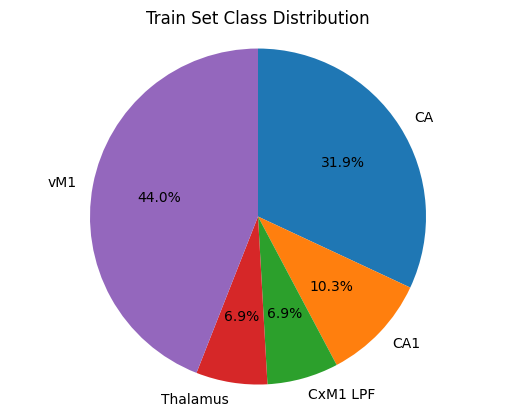

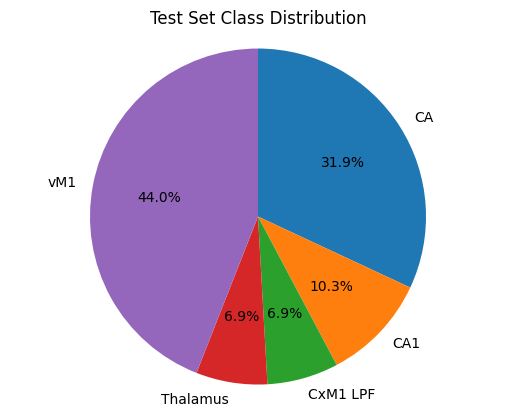

In [16]:
train_fig = plot_pie_chart(train_counts, class_names, "Train Set Class Distribution")
test_fig = plot_pie_chart(test_counts, class_names, "Test Set Class Distribution")


In [17]:
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model, loss function, and optimizer
input_size = 5000  # sequence length
num_classes = len(dataset.label_encoder.classes_)
model = SimpleNN(input_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
model

SimpleNN(
  (fc1): Linear(in_features=5000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [19]:
import mlflow
import mlflow.pytorch
mlflow.set_tracking_uri("http://mlflow:5000")

print('tracking uri:', mlflow.get_tracking_uri())


tracking uri: http://mlflow:5000


In [20]:
import mlflow
import mlflow.pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the experiment name
experiment_name = "IEEG_Classification_Baseline"

# Create a new experiment or set the existing one
mlflow.set_experiment(experiment_name)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model, loss function, and optimizer
input_size = 5000  # sequence length
num_classes = len(dataset.label_encoder.classes_)
model = SimpleNN(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and evaluation function
def train_and_evaluate(model, train_loader, test_loader, num_epochs=200):
    
    with mlflow.start_run(run_name="ANN-Baseline_NO_Response") as run:
        # Log parameters
        mlflow.log_param("epochs", num_epochs)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", 0.001)
        mlflow.log_param("model", "SimpleNN")
        mlflow.log_param("input_size", input_size)
        mlflow.log_param("num_classes", num_classes)
        mlflow.log_dict(dataset.get_class_mapping(), "class_mapping.json")

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            y_true_train = []
            y_pred_train = []
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels.squeeze())
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                y_true_train.extend(labels.squeeze().cpu().numpy())
                y_pred_train.extend(predicted.cpu().numpy())
            
            avg_loss = running_loss / len(train_loader)
            train_accuracy = accuracy_score(y_true_train, y_pred_train)
            precision, recall, f1, _ = precision_recall_fscore_support(y_true_train, y_pred_train, average='weighted')
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
            
            mlflow.log_metric("train_loss", avg_loss, step=epoch)
            mlflow.log_metric("train_accuracy", train_accuracy, step=epoch)
            mlflow.log_metric("train_precision", precision, step=epoch)
            mlflow.log_metric("train_recall", recall, step=epoch)
            mlflow.log_metric("train_f1", f1, step=epoch)

        model.eval()
        y_true_test = []
        y_pred_test = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                y_true_test.extend(labels.squeeze().cpu().numpy())
                y_pred_test.extend(predicted.cpu().numpy())
                
        test_accuracy = accuracy_score(y_true_test, y_pred_test)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true_test, y_pred_test, average='weighted')
        
        print(f'Accuracy of the model on the test data: {test_accuracy:.2f}%')
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
        
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_precision", precision)
        mlflow.log_metric("test_recall", recall)
        mlflow.log_metric("test_f1", f1)
        
        # Confusion matrix
        cm = confusion_matrix(y_true_test, y_pred_test)
        cm_df = pd.DataFrame(cm, index=dataset.label_encoder.classes_, columns=dataset.label_encoder.classes_)
        
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix')
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()
        
        # Log the model
        mlflow.pytorch.log_model(model, "model")

# Train and evaluate the model while tracking with MLflow
train_and_evaluate(model, train_loader, test_loader, num_epochs=200)


Epoch [1/200], Loss: 1.4512, Accuracy: 0.4129, Precision: 0.3472, Recall: 0.4129, F1 Score: 0.3683
Epoch [2/200], Loss: 1.3312, Accuracy: 0.4624, Precision: 0.3769, Recall: 0.4624, F1 Score: 0.3934
Epoch [3/200], Loss: 1.3087, Accuracy: 0.4700, Precision: 0.3680, Recall: 0.4700, F1 Score: 0.3951
Epoch [4/200], Loss: 1.2807, Accuracy: 0.4800, Precision: 0.3985, Recall: 0.4800, F1 Score: 0.4039
Epoch [5/200], Loss: 1.2724, Accuracy: 0.4751, Precision: 0.3596, Recall: 0.4751, F1 Score: 0.4007


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/200], Loss: 1.2586, Accuracy: 0.4844, Precision: 0.3679, Recall: 0.4844, F1 Score: 0.4065


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/200], Loss: 1.2422, Accuracy: 0.4854, Precision: 0.3719, Recall: 0.4854, F1 Score: 0.4073


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/200], Loss: 1.2373, Accuracy: 0.4915, Precision: 0.4623, Recall: 0.4915, F1 Score: 0.4139


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/200], Loss: 1.2238, Accuracy: 0.4913, Precision: 0.3993, Recall: 0.4913, F1 Score: 0.4143


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/200], Loss: 1.2143, Accuracy: 0.4983, Precision: 0.4158, Recall: 0.4983, F1 Score: 0.4242


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [11/200], Loss: 1.2102, Accuracy: 0.5002, Precision: 0.4482, Recall: 0.5002, F1 Score: 0.4313


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [12/200], Loss: 1.1972, Accuracy: 0.5023, Precision: 0.4314, Recall: 0.5023, F1 Score: 0.4354


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [13/200], Loss: 1.1863, Accuracy: 0.5014, Precision: 0.4469, Recall: 0.5014, F1 Score: 0.4376


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [14/200], Loss: 1.1820, Accuracy: 0.5021, Precision: 0.4466, Recall: 0.5021, F1 Score: 0.4397
Epoch [15/200], Loss: 1.1687, Accuracy: 0.5082, Precision: 0.4617, Recall: 0.5082, F1 Score: 0.4461


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [16/200], Loss: 1.1623, Accuracy: 0.5078, Precision: 0.4622, Recall: 0.5078, F1 Score: 0.4484
Epoch [17/200], Loss: 1.1520, Accuracy: 0.5114, Precision: 0.4655, Recall: 0.5114, F1 Score: 0.4529


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [18/200], Loss: 1.1476, Accuracy: 0.5204, Precision: 0.4674, Recall: 0.5204, F1 Score: 0.4628
Epoch [19/200], Loss: 1.1396, Accuracy: 0.5274, Precision: 0.5513, Recall: 0.5274, F1 Score: 0.4720


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [20/200], Loss: 1.1302, Accuracy: 0.5230, Precision: 0.4815, Recall: 0.5230, F1 Score: 0.4706


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [21/200], Loss: 1.1282, Accuracy: 0.5251, Precision: 0.4828, Recall: 0.5251, F1 Score: 0.4714
Epoch [22/200], Loss: 1.1195, Accuracy: 0.5277, Precision: 0.5188, Recall: 0.5277, F1 Score: 0.4775
Epoch [23/200], Loss: 1.1159, Accuracy: 0.5322, Precision: 0.5165, Recall: 0.5322, F1 Score: 0.4807
Epoch [24/200], Loss: 1.1082, Accuracy: 0.5373, Precision: 0.4997, Recall: 0.5373, F1 Score: 0.4893
Epoch [25/200], Loss: 1.1140, Accuracy: 0.5285, Precision: 0.4896, Recall: 0.5285, F1 Score: 0.4736
Epoch [26/200], Loss: 1.1046, Accuracy: 0.5367, Precision: 0.5234, Recall: 0.5367, F1 Score: 0.4871
Epoch [27/200], Loss: 1.0855, Accuracy: 0.5434, Precision: 0.5426, Recall: 0.5434, F1 Score: 0.4958
Epoch [28/200], Loss: 1.0899, Accuracy: 0.5416, Precision: 0.5218, Recall: 0.5416, F1 Score: 0.4960
Epoch [29/200], Loss: 1.0873, Accuracy: 0.5417, Precision: 0.5429, Recall: 0.5417, F1 Score: 0.4953
Epoch [30/200], Loss: 1.0809, Accuracy: 0.5394, Precision: 0.5213, Recall: 0.5394, F1 Score: 0.4908


/usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
